# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Вступление:
Для того, чтобы понять, какие тарифы предлагать клиентам с устаревшими тарифами, нам нужно обучить модель различать по косвенным признакам тарифы Ультра от Смарта.  

## 1. Откройте и изучите файл

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Итак, мы видим полностью предобработанные данные, таблица состоит из столбцов:
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [4]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Построив матрицу корреляции, я вижу, что между звонками и минутами есть высокая корелляция, это повод, чтобы исключить один из параметров!

## 2. Разбейте данные на выборки

Для обучения модели разделим параметры на целевые (is_ultra) и не целевые (все остальные). Исключаю из выборки столбец minutes. Все признаки, кроме целевого, запишем в переменную features, а целевой признак запишем в переменную target:

In [5]:
features = df.drop(['is_ultra', 'minutes'], axis=1)
target = df['is_ultra']

Далее разобьем данные на три части: обучающую, валидационную и тестовую, в пропорции 60/20/20. Сначала разобьем данные на две части общую и тестовую в пропорции 80/20:

In [6]:
features_trains, features_test, target_trains, target_test = train_test_split(features, target, test_size=.2, random_state=12345)

Затем для обучения модели разобьем общую часть на обучающую и валидационную в пропорции 75/25 (разбив 100 на 3 части мы получаем 60/20/20, первые 20 мы получили разбив 100 на 80/20, теперь из 80 нужно взять 20, то есть 25 процентов (20 / 80 = 0.25)):

In [7]:
features_train, features_valid, target_train, target_valid = train_test_split(features_trains, target_trains, test_size=.25, random_state=12345)

In [8]:
print('Длина обучающей выборки: {:.0%}'.format(len(features_train) / len(df)))
print('Длина валидационной выборки: {:.0%}'.format(len(features_valid) / len(df)))
print('Длина тестовой выборки: {:.0%}'.format(len(features_test) / len(df)))

Длина обучающей выборки: 60%
Длина валидационной выборки: 20%
Длина тестовой выборки: 20%


Данные готовы. 😀

## 3. Исследуйте модели

Исследуем разные алгоритмы обучения с разными параметрами. Так как в столбце is_ultra данные категориальные и представлены в виде 0 и 1, то задача сводится к бинарной классификации, нам подойдут три алгоритма обучения: дерево решений, случайный лес и логическая регрессия. Вначале исследуем "дерево решений":

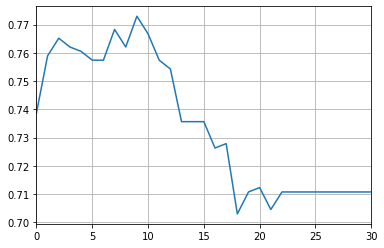

Accuracy наилучшей модели на валидационной выборке: 0.7729393468118196 Максимальная глубина: 10


In [9]:
import matplotlib.pyplot as plt 

series_1 = []
best_result = 0
max_deep = 0

for depth in range(1, 35):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    series_1.append(result)
    if result > best_result:
        best_result = result
        max_deep = depth
    
series_1 = pd.Series(series_1)
series_1.plot(grid=True, xlim=(0, 30))
plt.show()
print("Accuracy наилучшей модели на валидационной выборке:", best_result, "Максимальная глубина:", max_deep)

Модель показала наилучший аccuracy, равный 77 процентам при глубине дерева, равной 10. Далее эффективность снижается, поэтому остановимся на 10. Далее исследуем алгоритм "случайный лес":

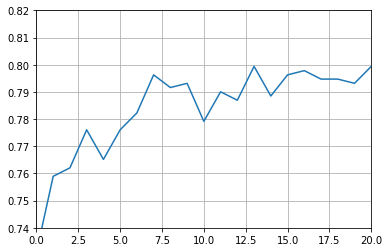

Accuracy наилучшей модели на валидационной выборке: 0.7993779160186625 Максимальная глубина: 14


In [10]:
series_2 = []
best_result = 0
max_deep = 0

for depth in range(1, 25):
    model = RandomForestClassifier(random_state=12345, n_estimators=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    series_2.append(result)
    if result > best_result:
        best_result = result
        max_deep = depth
    
series_2 = pd.Series(series_2)
series_2.plot(grid=True, xlim=(0, 20), ylim=(0.74, 0.82))
plt.show()
print("Accuracy наилучшей модели на валидационной выборке:", best_result, "Максимальная глубина:", max_deep)

Модель показала наилучший аccuracy, равный 79 процентам при глубине дерева, равной 14. Далее эффективность алгоритма падает, поэтому остановимся на 14. Далее исследуем алгоритм "логистической регрессии":

In [11]:
model = LogisticRegression(random_state=12345, solver='lbfgs')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)

print("Accuracy наилучшей модели на валидационной выборке:", result)

Accuracy наилучшей модели на валидационной выборке: 0.7356143079315708


Алгоритм "логистической регрессии" показал самый низкий процент, а именно 79%. Итак, самым эффективным алгоритмом оказался "случайный лес" с глубиной дерева, равной 14, поэтому выберем для обучения модели метод "случайный лес" с глубиной дерева 14. 

## 4. Проверьте модель на тестовой выборке

Теперь создадим модель, применив алгоритм "случайный лес" с глубиной дерева 14 и обучим ее на тренировочной выборке:

In [12]:
best_model = RandomForestClassifier(random_state=12345, n_estimators=14)
best_model.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=14,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

Модель готова. Попробуем сделать предсказание для тестовой выборки и посмотрим процент удачных исходов:

In [13]:
predictions_test = best_model.predict(features_test)
result = accuracy_score(target_test, predictions_test)
print("Наилучшей accuracy модели на тестовой выборке:", result)

Наилучшей accuracy модели на тестовой выборке: 0.7869362363919129


## Вывод:

Мы видим, что процент удачных исходов равен 78%, мы добились положительных результатов, т.к. поставленная задача была достигнуть 75% и более. Задача выполнена, результат достигнут. 😊